In [1]:
import pandas as pd
import numpy as np
import re
import geopy.distance
from scipy import stats
from category_encoders import  OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt  
import seaborn as sns  
import plotly.express as px
%matplotlib inline

from wordcloud import WordCloud

# инструменты для лингвистического анализа:
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer
from afinn import Afinn
nltk.download('vader_lexicon')

import warnings
pd.options.mode.chained_assignment = None # SettingWithCopyWarning ignore
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning ignore

from colorama import Fore, Back, Style

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
DATA_DIR = 'P:/_Data Scientist DSPR-107/EDA-7. PROJECT-3. Feature Engineering. Соревнование на Kaggle/data/sf-booking'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') 
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') 
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv')

RANDOM_SEED = 42 

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

# объединяем данные в один dataset
df = pd.concat([df_train, df_test], ignore_index=True)

data = df.copy()       

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Asylum\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<p style = "font-size : 30px; color : white ; text-align : left; background-color : #c0c0ff; border-radius: 5px 5px; padding : 10px"><img src="https://upload.wikimedia.org/wikipedia/commons/d/dd/Booking.com_Logo.svg" style="width:368px;height:81px;"></p>

<a id = '8'></a>
<p style="border:3px solid #a63bff;text-align:left; color: #a63bff; font-size: 40px;">  Оглавление: </p>


<style>
a {
    color: #a63bff !important;
    font-size: 25px !important;
}
</style>
* <a href="#0">0. Introduction</a>
* <a href="#1">1. Start</a>
  * <a href="#1.1">1.1 Объединение данных</a>
* <a href="#2">2. Исследование данных</a>
* <a href="#3">3. Проектирование данных</a>
  * <a href="#3.1">3.1 Анализ дат </a>
  * <a href="#3.2">3.2 Анализ отелей </a>
  * <a href="#3.3">3.3 Координаты расположения отелей</a>
    * <a href="#3.3.1">3.3.1 Расстояние до центра</a>
  * <a href="#3.4">3.4 Информация о рецензенте</a>
  * <a href="#3.5">3.5 Обработка отзывов</a>
  * <a href="#3.6">3.6 Tags</a>
* <a href="#4">4. Очистка данных</a>
* <a href="#5">5. Model</a>
  * <a href="#5.1">5.1 Получение средней абсолютной ошибки</a>
* <a href="#6">6. Conclusion</a>
* <a href="#7">7. Submission </a>  

<a id = '0'></a>
<p style = "background-color : #ac67ff; border-radius: 5px 5px; padding : 10px">
<p style="color: #b29aff; font-size: 50px;">
    <strong>0. Introduction</strong>
</p>

<span style="color:#b29aff; font-family: 'Microsoft Sans Serif', Arial, sans-serif; font-size: 20px">
  
  В этом проекте мы будем работать с датасетом, в котором содержатся сведения о более чем 515 000 отзывов на отели Европы и Великобритании. Модель, которую мы будем обучать, должна предсказывать рейтинг отеля по данным сайта <b style="color:#a63bff"><strong>Booking.com</strong></b> на основе имеющихся в датасете данных.

<b style="color:#a63bff"><strong>Цель проекта:</strong></b>
* Построить модель на основе алгоритма машинного обучения - RandomForestRegressor, предсказывающую рейтинг отеля.

<b style="color:#a63bff"><strong>Задачи проекта:</strong></b>
* Исследовать данные датасета;
* Спроектировать новые признаки;
* Выполнить подготовку данных, которые будут использованы для обучения модели;
* Изучить пример машинного обучения (scikit-learn класс RandomForestRegressor);
* Проверить эффективность предлагаемой модели, используя метрику MAPE;
* Принять участие в соревнованиях на площадке <b style="color:#a63bff"><strong>kaggle.com</strong></b>.
    
<b style="color:#a63bff; font-size: 30px"><strong>Описание данных</strong></b>
    
    
<table >
   <tr>
    <th>Признак</th>
    <th>Описание</th>
  </tr>
  
   <tr>
    <td>hotel_address</td>
    <td>адрес отеля </td>
  </tr>
    
   <tr>
    <td>additional_number_of_scoring</td>
    <td>кол-во оценок сервису, но без оставления отзыва </td>
  </tr> 
    
  <tr>
    <td>review_date</td>
    <td>дата, когда рецензент разместил отзыв </td>
  </tr>
    
  <tr>
    <td>average_score</td>
    <td>средний балл отеля, рассчитанный на основе последнего комментария за последний год </td>
  </tr>
    
   <tr>
    <td>hotel_name</td>
    <td>название отеля </td>
  </tr>
    
   <tr>
    <td>reviewer_nationality</td>
    <td>страна рецензента </td>
  </tr>
    
   <tr>
    <td>negative_review </td>
    <td>отрицательный отзыв, который рецензент дал отелю </td>
  </tr> 
   
   <tr>
    <td>review_total_negative_word_counts </td>
    <td>общее количество слов в отрицательном отзыве </td>
  </tr>  
    
   <tr>
    <td>total_number_of_reviews </td>
    <td>общее количество действительных отзывов об отеле </td>
  </tr>  
    
   <tr>
    <td>positive_review</td>
    <td>положительный отзыв, который рецензент дал отелю </td>
  </tr> 
    
   <tr>
    <td>review_total_positive_word_counts</td>
    <td>общее количество слов в положительном отзыве </td>
  </tr> 
    
  <tr>
    <td>total_number_of_reviews_reviewer_has_given</td>
    <td>количество отзывов, которые рецензенты дали в прошлом </td>
  </tr> 
    
   <tr>
    <td>reviewer_score</td>
    <td>оценка, которую рецензент поставил отелю </td>
  </tr> 
    
   <tr>
    <td>tags</td>
    <td>теги, которые рецензент дал отелю </td>
  </tr> 
    
   <tr>
    <td>days_since_review</td>
    <td>количество дней между датой проверки и датой очистки </td>
  </tr> 
    
   <tr>
    <td>lat</td>
    <td>географическая широта отеля </td>
  </tr> 
    
   <tr>
    <td>lng</td>
    <td>географическая долгота отеля </td>
  </tr> 
    
</table>


</span>

<a id = '1'></a>
<p style = "background-color : #ac67ff; border-radius: 5px 5px; padding : 10px">
<p style="color: #b29aff; font-size: 50px;">
    <strong>1. Start</strong>
</p>

<style>
a {
    color: #a63bff !important;
    font-size: 20px !important;
}
</style>
⮬ <a href="#8">к оглавлению</a>

In [1]:
%%capture

##############################################

# https://www.kaggle.com/code/fobosal/project-3-booking

# установка дополнительных библиотек:
# !pip install Afinn
# !pip install nltk[twitter]
# !pip install wordcloud
# !pip install spacy
#!pip install geopy 

#python -m spacy download en_core_web_lg
#python -m spacy download en_core_web_sm


import pandas as pd
import numpy as np
import re
import geopy.distance
from scipy import stats
from category_encoders import  OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt  
import seaborn as sns  
import plotly.express as px
%matplotlib inline

from wordcloud import WordCloud

# инструменты для лингвистического анализа:
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer
from afinn import Afinn
nltk.download('vader_lexicon')

import warnings
pd.options.mode.chained_assignment = None # SettingWithCopyWarning ignore
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning ignore

from colorama import Fore, Back, Style

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [2]:
# Для воспроизводимости зафиксируем RANDOM_SEED
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
#!pip freeze > requirements.txt

In [4]:
# данные из соревнования
#DATA_DIR = '/kaggle/input/sf-booking/'
#df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') 
#df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') 
#sample_submission = pd.read_csv(DATA_DIR+'/submission.csv')

DATA_DIR = 'P:/_Data Scientist DSPR-107/EDA-7. PROJECT-3. Feature Engineering. Соревнование на Kaggle/data/sf-booking'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') 
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') 
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [7]:
sample_submission.head(3)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


<a id = '1.1'></a>
<p style="color: #b29aff; font-size: 45px;">
    <strong>1.1 Объединение данных</strong>
</p>

<style>
a {
    color: #a63bff !important;
    font-size: 20px !important;
}
</style>
⮬ <a href="#8">к оглавлению</a>

In [8]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

# объединяем данные в один dataset
df = pd.concat([df_train, df_test], ignore_index=True)
#df['sample'] = df['sample'].astype('category')

In [9]:
data = df.copy()

<a id = '2'></a>
<p style = "background-color : #ac67ff; border-radius: 5px 5px; padding : 10px">
<p style="color: #b29aff; font-size: 50px;">
    <strong>2. Исследование данных</strong>
</p>

<style>
a {
    color: #a63bff !important;
    font-size: 20px !important;
}
</style>
⮬ <a href="#8">к оглавлению</a>

<span style="color:#b29aff; font-family: 'Microsoft Sans Serif', Arial, sans-serif; font-size: 20px">
  
Рассмотрим наш объединённый датасет
</span>

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

<span style="color:#b29aff; font-family: 'Microsoft Sans Serif', Arial, sans-serif; font-size: 20px">
  
Пропуски данных только в стобцах <b style="color:#a63bff"><strong>lat</strong></b> и <b style="color:#a63bff"><strong>lng</strong></b>.

</span>

In [11]:
print(Fore.LIGHTMAGENTA_EX + "\nКоличество отелей с отсутствующими координатами:",data[data['lat'].isnull()]['hotel_name'].nunique())


Количество отелей с отсутствующими координатами: 17


In [12]:
data.nunique()

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
reviewer_score                                    38
tags                                           55242
days_since_review                                731
lat                                             1472
lng                                             1472
sample                                             2
dtype: int64

<span style="color:#b29aff; font-family: 'Microsoft Sans Serif', Arial, sans-serif; font-size: 20px">
  
Видно, что количество уникальных отелей <b style="color:#a63bff"><strong>1493</strong></b>, а адресов <b style="color:#a63bff"><strong>1492</strong></b>.

</span>

In [13]:
# Создание нового DataFrame с уникальными значениями
unique_df = data.drop_duplicates()

# Группировка данных и сбор адресов в список для каждого отеля
grouped_addresses = unique_df.groupby('hotel_name')['hotel_address'].apply(list)

# Поиск отеля с двумя разными адресами
for hotel, addresses in grouped_addresses.iteritems():
    if len(set(addresses)) > 1:
        print("Отель:\n", hotel)
        print("Адреса:\n", addresses)
        print("-"*len(addresses))

Отель:
 Hotel Regina
Адреса:
 ['Bergara 2 4 Eixample 08002 Barcelona Spain', 'Bergara 2 4 Eixample 08002 Barcelona Spain', 'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria', 'Via Cesare Correnti 13 Milan City Center 20123 Milan Italy', 'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria', 'Bergara 2 4 Eixample 08002 Barcelona Spain', 'Bergara 2 4 Eixample 08002 Barcelona Spain', 'Bergara 2 4 Eixample 08002 Barcelona Spain', 'Bergara 2 4 Eixample 08002 Barcelona Spain', 'Bergara 2 4 Eixample 08002 Barcelona Spain', 'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria', 'Bergara 2 4 Eixample 08002 Barcelona Spain', 'Bergara 2 4 Eixample 08002 Barcelona Spain', 'Bergara 2 4 Eixample 08002 Barcelona Spain', 'Bergara 2 4 Eixample 08002 Barcelona Spain', 'Bergara 2 4 Eixample 08002 Barcelona Spain', 'Bergara 2 4 Eixample 08002 Barcelona Spain', 'Bergara 2 4 Eixample 08002 Barcelona Spain', 'Bergara 2 4 Eixample 08002 Barcelona Spain', 'Bergara 2 4 Eixample 08002 Barcelona Spain', 'Via C

<span style="color:#b29aff; font-family: 'Microsoft Sans Serif', Arial, sans-serif; font-size: 20px">
  
Получаем, что в трёх разных странах есть отель с одинаковым названием <b style="color:#a63bff"><strong>Hotel Regina</strong></b>, но тогда цифры всё равно но сходятся. Получается, что есть два отеля по одному адресу (возможно один отель был переименован).

</span>

In [14]:
grouped1_addresses = unique_df.groupby('hotel_address')['hotel_name'].apply(list)

# Поиск отелей с одним адресом
for address, hotel in grouped1_addresses.iteritems():
    if len(set(hotel)) > 1:
        print("Hotels:\n", set(hotel))
        print("Address:\n", address)
        print("-"*len(address))

Hotels:
 {'The Grand at Trafalgar Square', 'Club Quarters Hotel Trafalgar Square'}
Address:
 8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom
--------------------------------------------------------------------------


<span style="color:#b29aff; font-family: 'Microsoft Sans Serif', Arial, sans-serif; font-size: 20px">
  
Проверим датасет на дубликаты.

</span>

In [15]:
data_dubl_sum = data.duplicated().sum()

print(Fore.LIGHTMAGENTA_EX + "\nКоличество дубликатов:", data_dubl_sum)
print(Style.RESET_ALL)  # Сброс цветовых настроек


Количество дубликатов: 336



In [16]:
# Фильтруем и выводим все дубликаты
data_dubl = data[data.duplicated(keep=False)]
data_dubl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 672 entries, 1674 to 513653
Data columns (total 18 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   hotel_address                               672 non-null    object 
 1   additional_number_of_scoring                672 non-null    int64  
 2   review_date                                 672 non-null    object 
 3   average_score                               672 non-null    float64
 4   hotel_name                                  672 non-null    object 
 5   reviewer_nationality                        672 non-null    object 
 6   negative_review                             672 non-null    object 
 7   review_total_negative_word_counts           672 non-null    int64  
 8   total_number_of_reviews                     672 non-null    int64  
 9   positive_review                             672 non-null    object 
 10  review_t

<a id = '3'></a>
<p style = "background-color : #ac67ff; border-radius: 5px 5px; padding : 10px">
<p style="color: #b29aff; font-size: 50px;">
    <strong>3. Проектирование данных</strong>
</p>

<style>
a {
    color: #a63bff !important;
    font-size: 20px !important;
}
</style>
⮬ <a href="#8">к оглавлению</a>

<a id = '3.1'></a>
<p style="color: #b29aff; font-size: 45px;">
    <strong>3.1 Анализ дат</strong>
</p>

<span style="color:#b29aff; font-family: 'Microsoft Sans Serif', Arial, sans-serif; font-size: 20px">
  
Создадим новые признаки из даты: год, месяц.

</span>

In [17]:
data['review_date'] = pd.to_datetime(data['review_date'])
data['month']=pd.to_datetime(data['review_date']).dt.month
data['year']=pd.to_datetime(data['review_date']).dt.year

<a id = '3.2'></a>
<p style="color: #b29aff; font-size: 45px;">
    <strong>3.2 Анализ отелей</strong>
</p>

<style>
a {
    color: #a63bff !important;
    font-size: 20px !important;
}
</style>
⮬ <a href="#8">к оглавлению</a>

In [18]:
# исследуем данные о названии на наличие пропусков и дубликатов:
pivot_n = data[['hotel_address', 'hotel_name']].groupby(
    by='hotel_name'
).nunique()

name_rep = pivot_n[pivot_n['hotel_address'] != 1].index.to_list()
mask = data['hotel_name'].isin(name_rep)
addresses_rep = data[mask][['hotel_name', 'hotel_address']].value_counts()

print(Fore.LIGHTMAGENTA_EX + "\nДублирование названия отеля:")
print(Style.RESET_ALL)  # Сброс цветовых настроек

# Вывод значения DataFrame с цветом
print(Fore.CYAN + addresses_rep.to_string())



Дублирование названия отеля:

hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    590
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           284
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     60


In [19]:

# чтобы различать эти отели при анализе - добавим в название город:
data['hotel_name'] = data.apply(
    lambda row: (row['hotel_name'] + ' ' + row['hotel_address'].split()[-2])
    if (row['hotel_name'] in name_rep)
    else row['hotel_name'], axis=1)

mask = data['hotel_name'].str.contains(name_rep[0])

print(Fore.LIGHTMAGENTA_EX + "\nПроверим полученные изменения:")
print(Style.RESET_ALL)  # Сброс цветовых настроек

# Вывод значения DataFrame с цветом
print(Fore.CYAN + data[mask]['hotel_name'].value_counts().to_string())


Проверим полученные изменения:

Hotel Regina Barcelona    590
Hotel Regina Vienna       284
Hotel Regina Milan         60


In [20]:
#выбираем страну из адреса отеля
data['hotel_country'] = data['hotel_address'].apply(
    lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

print(Fore.LIGHTMAGENTA_EX + "\nКакие страны получились в датасете:")
print(Style.RESET_ALL)  # Сброс цветовых настроек

# Вывод значения DataFrame с цветом
country_counts = data['hotel_country'].value_counts()
print(Fore.CYAN + country_counts.to_string())


Какие страны получились в датасете:

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207


In [21]:
#выбираем город из адреса отеля
data['hotel_city'] = data['hotel_address'].apply\
(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])

print(Fore.LIGHTMAGENTA_EX + "\nКакие города получились в датасете:")
print(Style.RESET_ALL)  # Сброс цветовых настроек

# Вывод значения DataFrame с цветом
city_counts = data['hotel_city'].value_counts()
print(Fore.CYAN + city_counts.to_string())


Какие города получились в датасете:

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207


<span style="color:#b29aff; font-family: 'Microsoft Sans Serif', Arial, sans-serif; font-size: 20px">
  
Мы видим, что в датасете 6 стран и 6, соответственно, их крупных городов.

Посмотрим зависимость средней оценки от города:

</span>

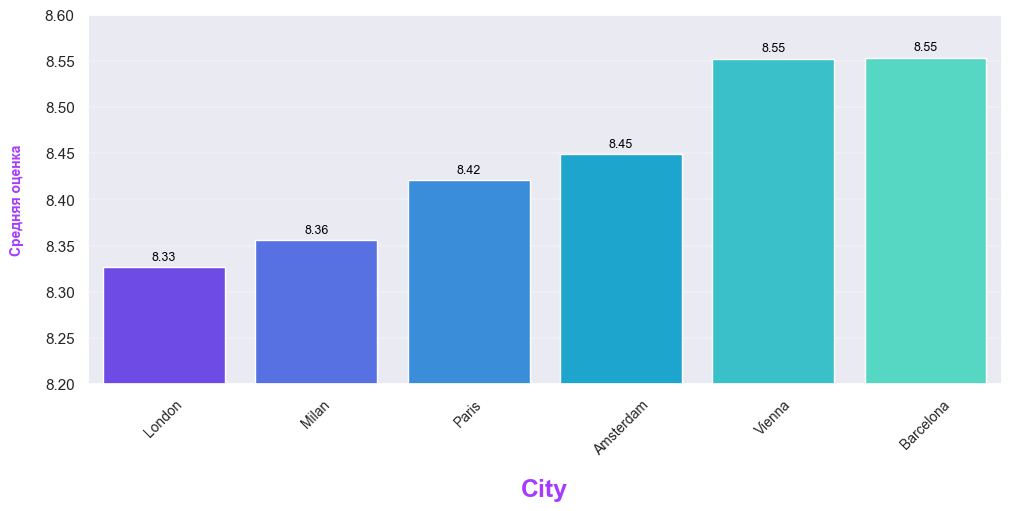

In [22]:
cities = pd.pivot_table(
    data=data[data['sample']==1],
    index='hotel_city', 
    values='reviewer_score', 
    aggfunc=['mean'])

# Сортировка данных по столбцу 'mean'
cities.sort_values(by=('mean', 'reviewer_score'), inplace=True)

sns.set(rc={"grid.linewidth": 0.3})
sns.set_style("darkgrid")

fig, ax1 = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax1.set_ylim(8.2, 8.6)

pal = sns.color_palette("rainbow", 15)
sns.set_palette(pal)

# Построение столбчатой диаграммы с упорядоченными данными 
sns.barplot(x=cities.index, y=cities[('mean', 'reviewer_score')],
            ax=ax1)

# Добавление значений на каждый столбец
for index, value in enumerate(cities[('mean', 'reviewer_score')]):
    ax1.annotate(round(value, 2), xy=(index, value), xytext=(0, 5),
                 textcoords="offset points", ha='center', fontsize=9, color='black')

ax1.tick_params(axis='x', rotation=45, labelsize=10)

# Подписи осей
ax1.set_xlabel('City', fontsize=18, labelpad=15,
               fontdict={'color': '#a63bff', 'fontweight': 600})
ax1.set_ylabel('Средняя оценка', fontsize=10, labelpad=15,
               fontdict={'color': '#a63bff', 'fontweight': 600})

plt.show()

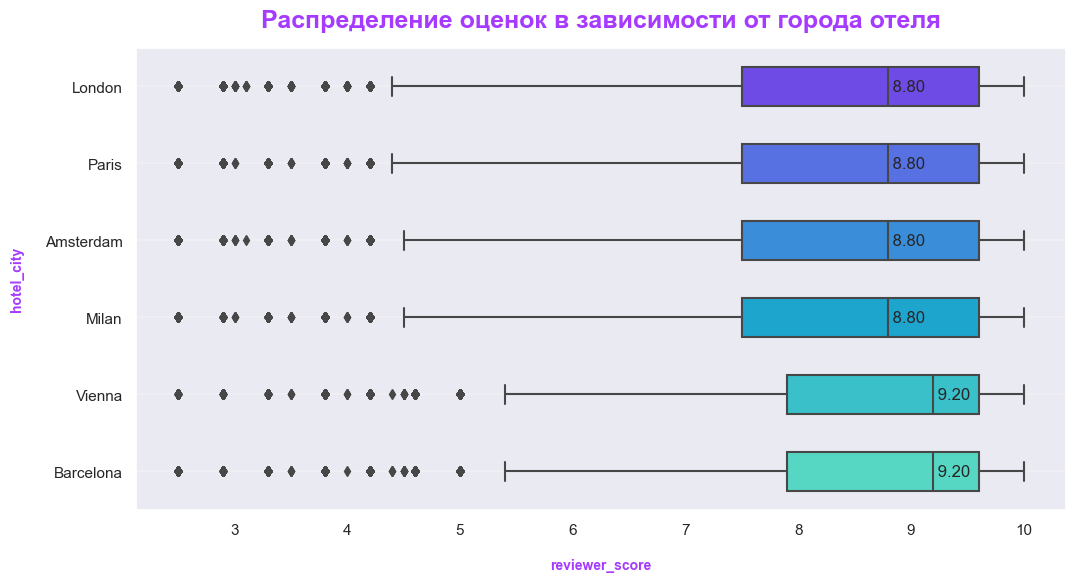

In [23]:
# Вычисляем медианные значения для каждой страны
fig = plt.figure(figsize=(12, 6))

# Фильтруем данные для выборки 'sample' == 1
data_sample_1 = data[data['sample'] == 1]

boxplot = sns.boxplot(
    data=data_sample_1,
    y='hotel_city',
    x='reviewer_score',
    orient='h',
    width=0.5
)

medians = data_sample_1.groupby('hotel_city')['reviewer_score'].median()

# Вставляем медианные значения на график с двумя знаками после запятой
for tick, label in enumerate(boxplot.get_yticklabels()):
    country = label.get_text()
    median_value = medians.get(country)
    boxplot.text(median_value, tick, f" {median_value:.2f}", verticalalignment='center')

boxplot.set_title('Распределение оценок в зависимости от города отеля', fontsize=18, pad=15,
               fontdict={'color': '#a63bff', 'fontweight': 600})
boxplot.set_xlabel('reviewer_score', fontsize=10, labelpad=15,
               fontdict={'color': '#a63bff', 'fontweight': 600})
boxplot.set_ylabel('hotel_city', fontsize=10, labelpad=15,
               fontdict={'color': '#a63bff', 'fontweight': 600})

boxplot.grid()

plt.show()

In [24]:
# Закодируем название стран
data = pd.get_dummies(data, columns=['hotel_country'], prefix='hotel_country')

<span style="color:#b29aff; font-family: 'Microsoft Sans Serif', Arial, sans-serif; font-size: 20px">
  
Теперь у нас в датасете будут новые признаки, каждый из которых соответствует одной уникальной стране

</span>

In [25]:
data.sample(3).iloc[:, -7:]

,hotel_city,hotel_country_Austria,hotel_country_France,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom
160613,London,0,0,0,0,0,1
124335,Vienna,1,0,0,0,0,0
174261,London,0,0,0,0,0,1


<a id = '3.3'></a>
<p style="color: #b29aff; font-size: 45px;">
    <strong>3.3 Координаты расположения отелей </strong>
</p>

<style>
a {
    color: #a63bff !important;
    font-size: 20px !important;
}
</style>
⮬ <a href="#8">к оглавлению</a>

In [26]:
print(Fore.LIGHTMAGENTA_EX + "\nКоличество отелей с отсутствующими координатами:",data[data['lat'].isnull()]['hotel_name'].nunique())


Количество отелей с отсутствующими координатами: 17


In [27]:
#поиск пропусков в данных

null_data = data.isnull().sum()

print(Fore.LIGHTMAGENTA_EX + "\nСтолбцы с пропусками данных:")
print(Style.RESET_ALL)  # Сброс цветовых настроек

# Вывод значения DataFrame с цветом
print(Fore.CYAN + null_data[null_data > 0].to_string())


Столбцы с пропусками данных:

lat    3268
lng    3268


In [28]:
# Проверяем, что пропуски в столбцах 'lat' и 'lng' находятся одновременно
mask_both_columns = data['lat'].isnull() & data['lng'].isnull()

# Считаем количество записей, где оба столбца содержат пропуски
count_both_columns_missing = data[mask_both_columns].shape[0]

# Выводим результат
print(Fore.LIGHTMAGENTA_EX + "\nКоличество записей с пропусками в обоих столбцах 'lat' и 'lng':",count_both_columns_missing)
print(Style.RESET_ALL)  # Сброс цветовых настроек


Количество записей с пропусками в обоих столбцах 'lat' и 'lng': 3268



In [29]:
# Группируем по отелям и посмотрим у каких отелей отсутствуют геоданные
hotels_no_coor = data[data[['lng', 'lat']].isnull().all(axis=1)].groupby(['hotel_name', 'hotel_city'])\
    .size().reset_index(name='count').sort_values(by='count', ascending=False).reset_index(drop=True)

# Изменение индекса, начиная с 1
hotels_no_coor.index = hotels_no_coor.index + 1

display(hotels_no_coor)

,hotel_name,hotel_city,count
1,Fleming s Selection Hotel Wien City,Vienna,658
2,Hotel City Central,Vienna,563
3,Hotel Atlanta,Vienna,389
4,Maison Albar Hotel Paris Op ra Diamond,Paris,290
5,Hotel Daniel Vienna,Vienna,245
6,Hotel Pension Baron am Schottentor,Vienna,223
7,Austria Trend Hotel Schloss Wilhelminenberg Wien,Vienna,194
8,Derag Livinghotel Kaiser Franz Joseph Vienna,Vienna,147
9,NH Collection Barcelona Podium,Barcelona,146
10,City Hotel Deutschmeister,Vienna,93


<span style="color:#b29aff; font-family: 'Microsoft Sans Serif', Arial, sans-serif; font-size: 20px">
  
- Пропуски содержатся в 2х признаках "lat" и "lng", количество записей составляет <b style="color:#a63bff"><strong>3268</strong></b> в каждом признаке;
- Количество уникальных значений составляет - <b style="color:#a63bff"><strong>17</strong></b>, по которым не заполнена информация по широте и долготе;
- С учетом малого количества информации в ручном режиме с помощью адреса отеля определить данные широты и долготы и внести информацию в таблицу.

</span>

In [30]:
# формируем словарь с данными по широте
dict_lat = {'Austria Trend Hotel Schloss Wilhelminenberg Wien': '48.21974808057666', 
                'Holiday Inn Paris Montmartre': '48.889064368690235',
                'Fleming s Selection Hotel Wien City': '48.20949471863499',
                'Hotel Atlanta': '48.2209723965124',
                'Maison Albar Hotel Paris Op ra Diamond': '48.87543722920124',
                'Derag Livinghotel Kaiser Franz Joseph Vienna': '48.24608017805536',
                'Hotel City Central': '48.214201786014854',
                'NH Collection Barcelona Podium': '41.39176529029773',
                'City Hotel Deutschmeister': '48.22103057609981',
                'Hotel Daniel Vienna': '48.18897212994251',
                'Roomz Vienna': '48.22382961585223',
                'Hotel Pension Baron am Schottentor': '48.21692824899107',
                'Mercure Paris Gare Montparnasse': '48.84010021974514',
                'Hotel Park Villa': '48.23759024291264',
                'Hotel Advance': '41.38327316014033',
                'Renaissance Barcelona Hotel': '41.394162363243964',
                'Cordial Theaterhotel Wien': '48.20969901650749'}

In [31]:
# формируем словарь с данными по долготе
dict_lng = {'Austria Trend Hotel Schloss Wilhelminenberg Wien': '16.285624283904383', 
                'Holiday Inn Paris Montmartre': '2.333206641604505',
                'Fleming s Selection Hotel Wien City': '16.35350997041095',
                'Hotel Atlanta': '16.356650516337886',
                'Maison Albar Hotel Paris Op ra Diamond': '2.3234027262612256',
                'Derag Livinghotel Kaiser Franz Joseph Vienna': '16.34202545691955',
                'Hotel City Central': '16.379923233140797',
                'NH Collection Barcelona Podium': '2.1783660658934747',
                'City Hotel Deutschmeister': '16.366622226233126',
                'Hotel Daniel Vienna': '16.3838329415743',
                'Roomz Vienna': '16.393969343883455',
                'Hotel Pension Baron am Schottentor': '16.360055901096636',
                'Mercure Paris Gare Montparnasse': '2.3231778953046462',
                'Hotel Park Villa': '16.34703938556462',
                'Hotel Advance': '2.162964217594162',
                'Renaissance Barcelona Hotel': '2.1748749075722924',
                'Cordial Theaterhotel Wien': '16.351495483903957'}

In [32]:
# формируем код и производим заполнение данных в dataframe
data['lat'] = data.apply(lambda x: dict_lat.get(x['hotel_name']) if pd.isnull(x['lat']) else x['lat'], axis=1).astype('float64') # вводим данные по широте и устанавливаем тип float64
data['lng'] = data.apply(lambda x: dict_lng.get(x['hotel_name']) if pd.isnull(x['lng']) else x['lng'], axis=1).astype('float64') # вводим данные по долготе и устанавливаем тип float64

In [33]:
# формируем и выводим повторно информацию о наличие пропусков после обработки
display(data.isnull().sum())

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
month                                         0
year                                          0
hotel_city                              

<a id = '3.3.1'></a>
<p style="color: #b29aff; font-size: 40px;">
    <strong>3.3.1 Расстояние до центра</strong>
</p>

<style>
a {
    color: #a63bff !important;
    font-size: 20px !important;
}
</style>
⮬ <a href="#8">к оглавлению</a>

In [34]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.extra.rate_limiter import RateLimiter

In [35]:
# Создаем объект геокодера с RateLimiter
geolocator = Nominatim(user_agent="Booking_Kaggle_2023")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.3)

def calculate_distance_to_city_center(row):
    location = geocode(row['hotel_city'])
    if location is not None:
        city_center_coords = (location.latitude, location.longitude)
        hotel_coords = (row['lat'], row['lng'])
        return geodesic(city_center_coords, hotel_coords).kilometers
    else:
        return None

# Создаем новый датасет с уникальными отелями и их координатами
unique_hotels = data[['hotel_name', 'lat', 'lng', 'hotel_city']].drop_duplicates(subset='hotel_name')

# Добавляем столбец с расстояниями в новый датасет с уникальными отелями
unique_hotels['distance_to_city_center'] = unique_hotels.apply(calculate_distance_to_city_center, axis=1)

# Теперь у нас есть датасет unique_hotels, содержащий уникальные отели и соответствующие расстояния до центров городов
data = data.merge(unique_hotels[['hotel_name', 'distance_to_city_center']], on='hotel_name', how='left')


In [36]:
data.sample(3).iloc[:, -8:]

,hotel_city,hotel_country_Austria,hotel_country_France,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom,distance_to_city_center
92239,Amsterdam,0,0,0,1,0,0,2.781710
243559,Paris,0,1,0,0,0,0,0.501677
4514,London,0,0,0,0,0,1,1.872280


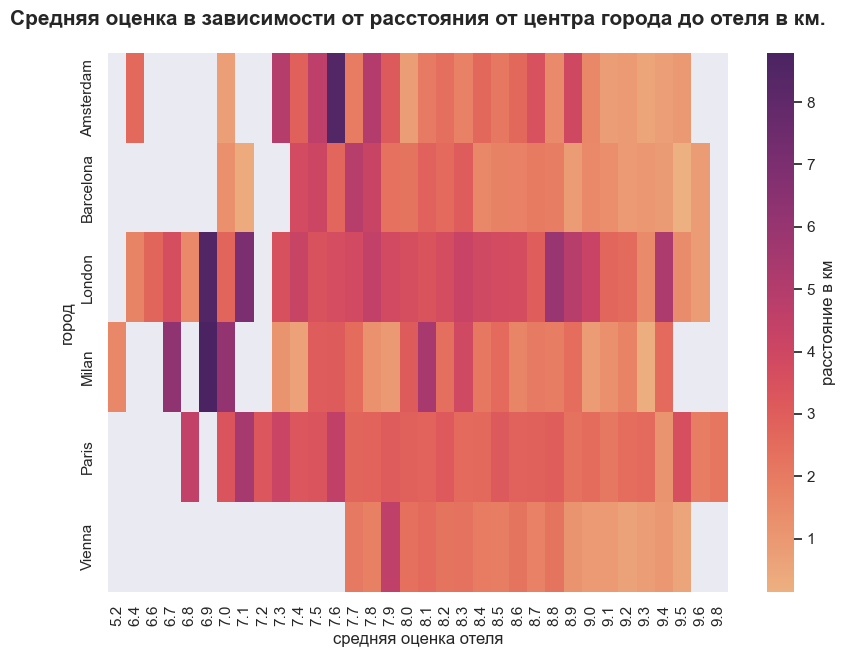

In [37]:
pivot_distance = data[data['sample']==1].pivot_table(
    values='distance_to_city_center',
    columns='average_score',
    index='hotel_city')
pivot_distance.columns = pivot_distance.columns.astype('string')
fig, ax = plt.subplots(figsize=(10,7))    
heatmap = sns.heatmap(data=pivot_distance, cmap='flare', 
                      cbar_kws={'label': 'расстояние в км'})
heatmap.set_title('Средняя оценка в зависимости от расстояния от центра города до отеля в км.',
                  fontsize=15, fontweight='bold', pad=20);
heatmap.set_xlabel('средняя оценка отеля');
heatmap.set_ylabel('город');


In [38]:
# удаляем теперь не нужные признаки
data.drop(['lat','lng'], axis = 1, inplace=True)

<a id = '3.4'></a>
<p style="color: #b29aff; font-size: 45px;">
    <strong>3.4 Информация о рецензенте</strong>
</p>

<style>
a {
    color: #a63bff !important;
    font-size: 20px !important;
}
</style>
⮬ <a href="#8">к оглавлению</a>

In [2]:
data['reviewer_nationality'].sample(5)

40610      United Kingdom 
142670     United Kingdom 
472718            Germany 
154717          Australia 
453253            Belgium 
Name: reviewer_nationality, dtype: object

In [3]:
data['reviewer_nationality'].describe()

count               515738
unique                 227
top        United Kingdom 
freq                245246
Name: reviewer_nationality, dtype: object

In [41]:

print(Fore.LIGHTMAGENTA_EX + "\nКоличество уникальных национальностей reviewer-ров:",data['reviewer_nationality'].nunique())


Количество уникальных национальностей reviewer-ров: 227


In [42]:
top_value = data['reviewer_nationality'].value_counts().idxmax()
print(Fore.LIGHTMAGENTA_EX + "\nИз какой страны больше всего reviewer-ров:", top_value)


Из какой страны больше всего reviewer-ров:  United Kingdom 


In [43]:
freq_value = data['reviewer_nationality'].value_counts().max()
print(Fore.LIGHTMAGENTA_EX + "\nОбщее количество reviewer-ров из самой часто встречающейся страны: ",freq_value)


Общее количество reviewer-ров из самой часто встречающейся страны:  245246


In [44]:
# Null записей нет, но проверим на всякий случай, нет ли пустых записей
cnt_no_nationality = data[data.reviewer_nationality.str.strip() == ''].shape[0]
print(Fore.LIGHTMAGENTA_EX + "\nКоличество записей без указанной национальности reviewer-а:",cnt_no_nationality)


Количество записей без указанной национальности reviewer-а: 523


In [45]:
# заполним модой
mode_country_reviewer = data.reviewer_nationality.mode().item()
data.loc[data[data.reviewer_nationality.str.strip() == ''].index,'reviewer_nationality'] = mode_country_reviewer

In [46]:
data1 = data[data['sample'] == 1]
data1 = data1.groupby('reviewer_nationality')['reviewer_score'].agg('mean').reset_index().sort_values(by='reviewer_score')
data1.rename(columns={'reviewer_nationality': 'национальность','reviewer_score': 'средняя_оценка'}, inplace=True)
print(Fore.LIGHTMAGENTA_EX + "\nCгруппириуем по национальностям для получения средней оценки:")
print(Style.RESET_ALL)  # Сброс цветовых настроек

print(Fore.CYAN + data1.sample(5).to_string())


Cгруппириуем по национальностям для получения средней оценки:

          национальность  средняя_оценка
72     French Polynesia         8.950000
62    Equatorial Guinea        10.000000
220   Wallis and Futuna         7.300000
101             Jamaica         8.140000
70               France         8.146978


In [47]:
countries_top = data['reviewer_nationality'].value_counts().nlargest(20)
countries_top.index = countries_top.index.map(str.strip)

print(Fore.LIGHTMAGENTA_EX + "\nТоп 20 по количеству отзывов:")
print(Style.RESET_ALL)  # Сброс цветовых настроек

# Вывод значения DataFrame с цветом
print(Fore.CYAN + countries_top.to_string())


Топ 20 по количеству отзывов:

United Kingdom              245769
United States of America     35437
Australia                    21686
Ireland                      14827
United Arab Emirates         10235
Saudi Arabia                  8951
Netherlands                   8772
Switzerland                   8678
Germany                       7941
Canada                        7894
France                        7296
Israel                        6610
Italy                         6114
Belgium                       6031
Turkey                        5444
Kuwait                        4920
Spain                         4737
Romania                       4552
Russia                        3900
South Africa                  3821


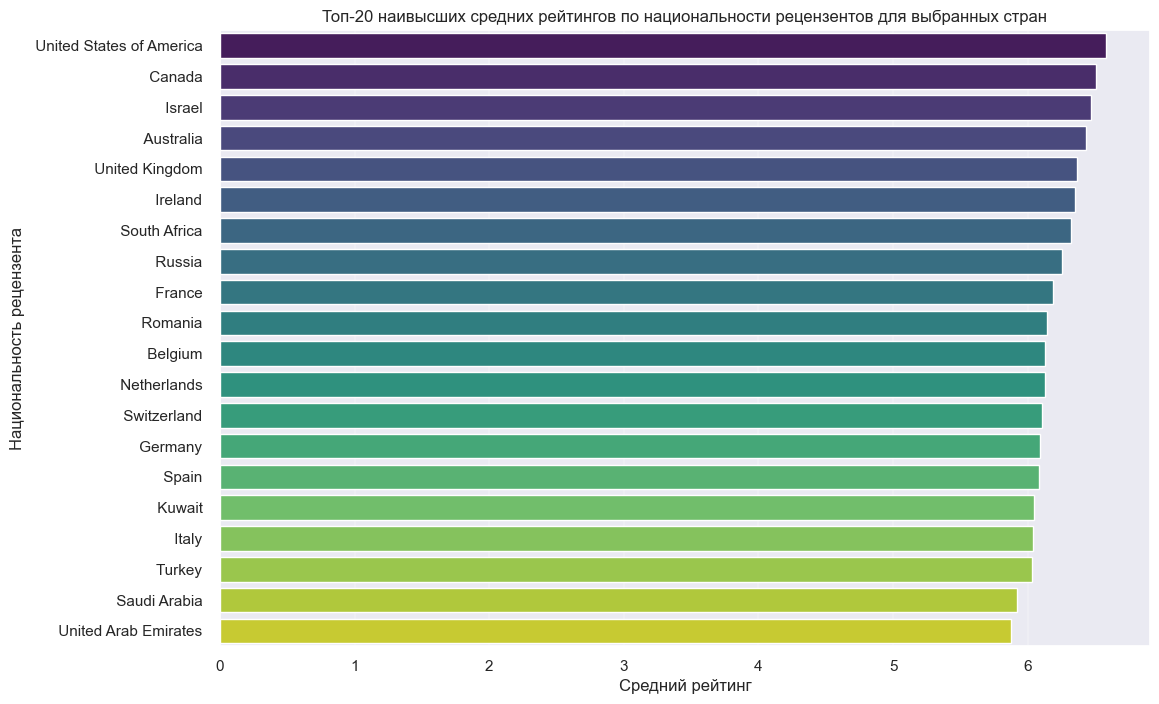

In [48]:
# Получим список топ-20 стран по количеству отзывов
countries_top = data['reviewer_nationality'].value_counts().nlargest(20).index.tolist()

# Фильтруем данные, оставляем только отзывы из топ-20 стран
data_filtered = data[data['reviewer_nationality'].isin(countries_top)]

# Группируем данные по 'reviewer_nationality' и вычисляем среднее значение 'reviewer_score'
data1 = data_filtered.groupby('reviewer_nationality')['reviewer_score'].agg('mean').reset_index()

# Сортируем значения по 'reviewer_score' в убывающем порядке
data1 = data1.sort_values(by='reviewer_score', ascending=False)

# Построение графика
plt.figure(figsize=(12, 8))
sns.barplot(x='reviewer_score', y='reviewer_nationality', data=data1, palette='viridis')
plt.xlabel('Средний рейтинг')
plt.ylabel('Национальность рецензента')
plt.title('Топ-20 наивысших средних рейтингов по национальности рецензентов для выбранных стран')
plt.show()


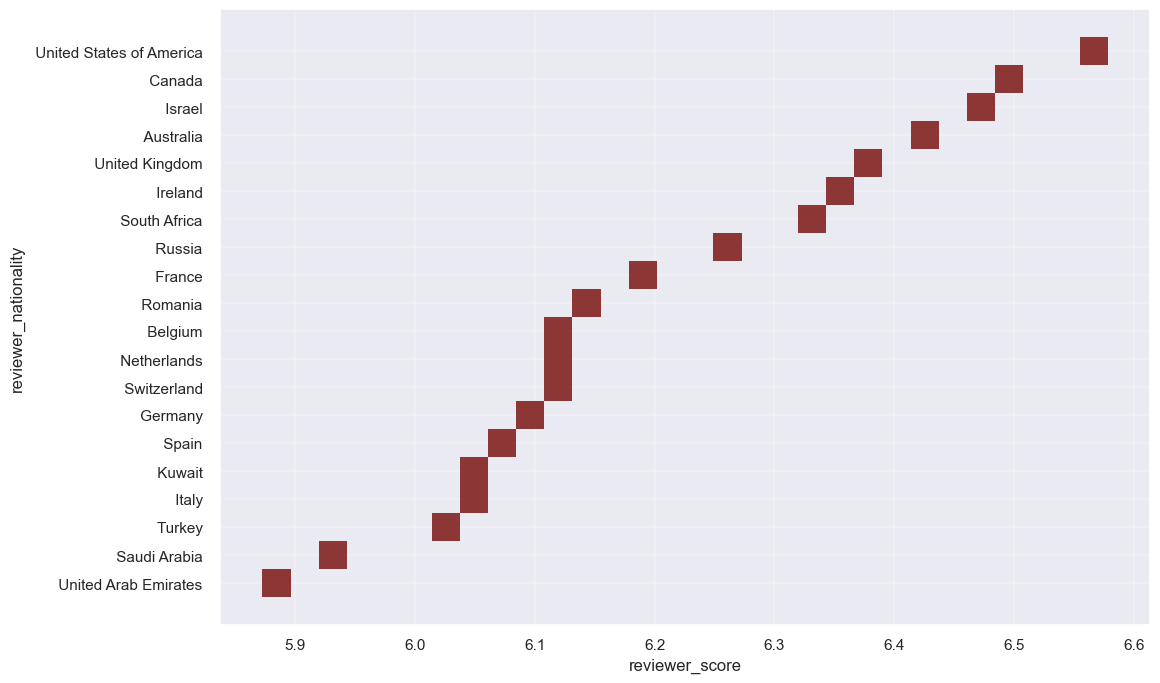

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

sns.histplot(
    data=data1,
    x='reviewer_score',
    y='reviewer_nationality',
    bins=30,
    color='red',
    ax=axes  
)

plt.show()

In [3]:
import category_encoders as ce
import pandas as pd

# Создаем объект BinaryEncoder
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])

# Преобразуем столбец reviewer_nationality в тип "category"
data['reviewer_nationality'] = data['reviewer_nationality'].astype('category')

# Применяем BinaryEncoder к столбцу reviewer_nationality и сохраняем результаты в новых столбцах
encoded_data = bin_encoder.fit_transform(data['reviewer_nationality'])

# Переименовываем столбцы с префиксом "nationality"
new_columns = [f"nationality_{i}" for i in range(encoded_data.shape[1])]
encoded_data.columns = new_columns

# Объединяем закодированные столбцы с исходными данными
data = pd.concat([data, encoded_data], axis=1)


In [4]:
data.sample(3).iloc[:, -9:]

,sample,nationality_0,nationality_1,nationality_2,nationality_3,nationality_4,nationality_5,nationality_6,nationality_7
95937,1,0,0,0,1,0,1,1,0
14916,1,0,0,0,0,0,0,0,1
60178,1,0,0,0,0,0,0,0,1


<a id = '3.5'></a>
<p style="color: #b29aff; font-size: 45px;">
    <strong>3.5 Обработка отзывов</strong>
</p>

<style>
a {
    color: #a63bff !important;
    font-size: 20px !important;
}
</style>
⮬ <a href="#8">к оглавлению</a>

In [52]:
%%time

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Первым делов подправим явные выражения 
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('N A', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('All good', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('No complaints', 'Positive'))
data['negative_review'] = data['negative_review'].apply(
    lambda x: x.replace('Nothing to dislike', 'Positive'))
data['positive_review'] = data['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

# создаем два экземпляра анализатора, чтобы разделить лексикон 
# для разной системы оценки положительных и отрицательных отзывов:
sia_neg = SentimentIntensityAnalyzer()
sia_pos = SentimentIntensityAnalyzer()

data['neg_scores'] = data['negative_review'].apply(lambda x: sia_neg.polarity_scores(x))
data['pos_scores'] = data['positive_review'].apply(lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
data['n_review_sentiments_neg'] = data['neg_scores'].apply(lambda x: x['neg'])
data['n_review_sentiments_neu'] = data['neg_scores'].apply(lambda x: x['neu'])
data['n_review_sentiments_pos'] = data['neg_scores'].apply(lambda x: x['pos'])
data['n_review_sentiments_compound'] = data['neg_scores'].apply(lambda x: x['compound'])

data['p_review_sentiments_neg'] = data['pos_scores'].apply(lambda x: x['neg'])
data['p_review_sentiments_neu'] = data['pos_scores'].apply(lambda x: x['neu'])
data['p_review_sentiments_pos'] = data['pos_scores'].apply(lambda x: x['pos'])
data['p_review_sentiments_compound'] = data['pos_scores'].apply(lambda x: x['compound'])


CPU times: total: 3min 18s
Wall time: 3min 19s


In [53]:
data.sample(3).iloc[:, -9:]

,pos_scores,n_review_sentiments_neg,n_review_sentiments_neu,n_review_sentiments_pos,n_review_sentiments_compound,p_review_sentiments_neg,p_review_sentiments_neu,p_review_sentiments_pos,p_review_sentiments_compound
428570,"{'neg': 0.0, 'neu': 0.306, 'pos': 0.694, 'comp...",0.106,0.775,0.119,0.0704,0.0,0.306,0.694,0.9274
2447,"{'neg': 0.0, 'neu': 0.39, 'pos': 0.61, 'compou...",0.000,1.000,0.000,0.0000,0.0,0.390,0.610,0.9571
51206,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,1.0,0.000,0.000,-0.5719


<a id = '3.6'></a>
<p style="color: #b29aff; font-size: 45px;">
    <strong>3.6 Tags</strong>
</p>

<style>
a {
    color: #a63bff !important;
    font-size: 20px !important;
}
</style>
⮬ <a href="#8">к оглавлению</a>

In [54]:
# Пример тега
data['tags'][5]

"[' Business trip ', ' Solo traveler ', ' Superior Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']"

In [55]:
len(data['tags'][5].split(','))

5

<span style="color:#b29aff; font-family: 'Microsoft Sans Serif', Arial, sans-serif; font-size: 20px">
  
Создаем новый признак <b style="color:#a63bff"><strong>len_tags</strong></b>, основанный на количестве тегов в отзыве.

</span>

In [56]:
data['len_tags'] = data['tags'].apply(lambda x: len(x.split(',')))

In [57]:
print(Fore.LIGHTMAGENTA_EX + "\nМаксимальное количество тегов в 1 строке данных:", data["len_tags"].max())


Максимальное количество тегов в 1 строке данных: 6


In [58]:
print(Fore.LIGHTMAGENTA_EX + "Примеры max 6 tags:\n")
print(data[data['len_tags'] == data['len_tags'].max()]['tags'].iloc[0])
print(data[data['len_tags'] == data['len_tags'].max()]['tags'].iloc[1])

Примеры max 6 tags:

[' With a pet ', ' Leisure trip ', ' Solo traveler ', ' Standard Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
[' With a pet ', ' Leisure trip ', ' Group ', ' Superior Twin Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']


In [59]:
# Abstract Syntax Trees - Абстрактные синтаксические деревья для поиска уникальных тегов
import ast

def find_unique_tags(df):
    unique_tags = set()
    for tags_list in df['tags']:
        tags_list = ast.literal_eval(tags_list)
        unique_tags.update(tags_list)
    return unique_tags

unique_tags = find_unique_tags(data)
#print(unique_tags)

In [60]:
print(Fore.LIGHTMAGENTA_EX + "\n Уникальное количество тегов составляет:",len(unique_tags))


 Уникальное количество тегов составляет: 2428


In [61]:
# формируем код функции для очистки tags
def get_change_tags(args):
    new_list = []
    clean = args.replace("'", "").replace("[","").replace("]","").split(",")
    for i in clean:
        j = i.strip()
        new_list.append(j)

    return new_list

In [62]:
# формируем код и производим очистку данных
data['tags'] = data['tags'].apply(get_change_tags)

In [63]:
# формируем код и выводим количественные данные использования тегов - 10 первых позиций
data['tags'].explode().value_counts().head(10)

Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Name: tags, dtype: int64

In [64]:
# формируем код и вывоводим лист 10 первых tags
tags_list = data['tags'].explode().value_counts().head(10).index.tolist()
display(tags_list)

['Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children']

In [65]:
# формируем код функции которая создает новые признаки из признаков tags
def add_tags(df, list):
    for review in list:
        col_name = "tags_" + review.lower()
        df[col_name] = df['tags'].apply(lambda x: 1 if review in x else 0)
    return df

In [66]:
# формируем код и производим создание бинарных признаков из tags
data = add_tags(data, tags_list)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 55 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  category      
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [67]:
data.sample(3).iloc[:, -11:]

,len_tags,tags_leisure trip,tags_submitted from a mobile device,tags_couple,tags_stayed 1 night,tags_stayed 2 nights,tags_solo traveler,tags_stayed 3 nights,tags_business trip,tags_group,tags_family with young children
279003,5,1,1,0,0,0,0,1,0,0,1
228527,5,1,1,0,0,0,0,1,0,0,1
187187,4,1,0,1,0,1,0,0,0,0,0


<a id = '4'></a>
<p style = "background-color : #ac67ff; border-radius: 5px 5px; padding : 10px">
<p style="color: #b29aff; font-size: 50px;">
    <strong>4. Очистка данных</strong>
</p>

<style>
a {
    color: #a63bff !important;
    font-size: 20px !important;
}
</style>
⮬ <a href="#8">к оглавлению</a>

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 55 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  category      
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

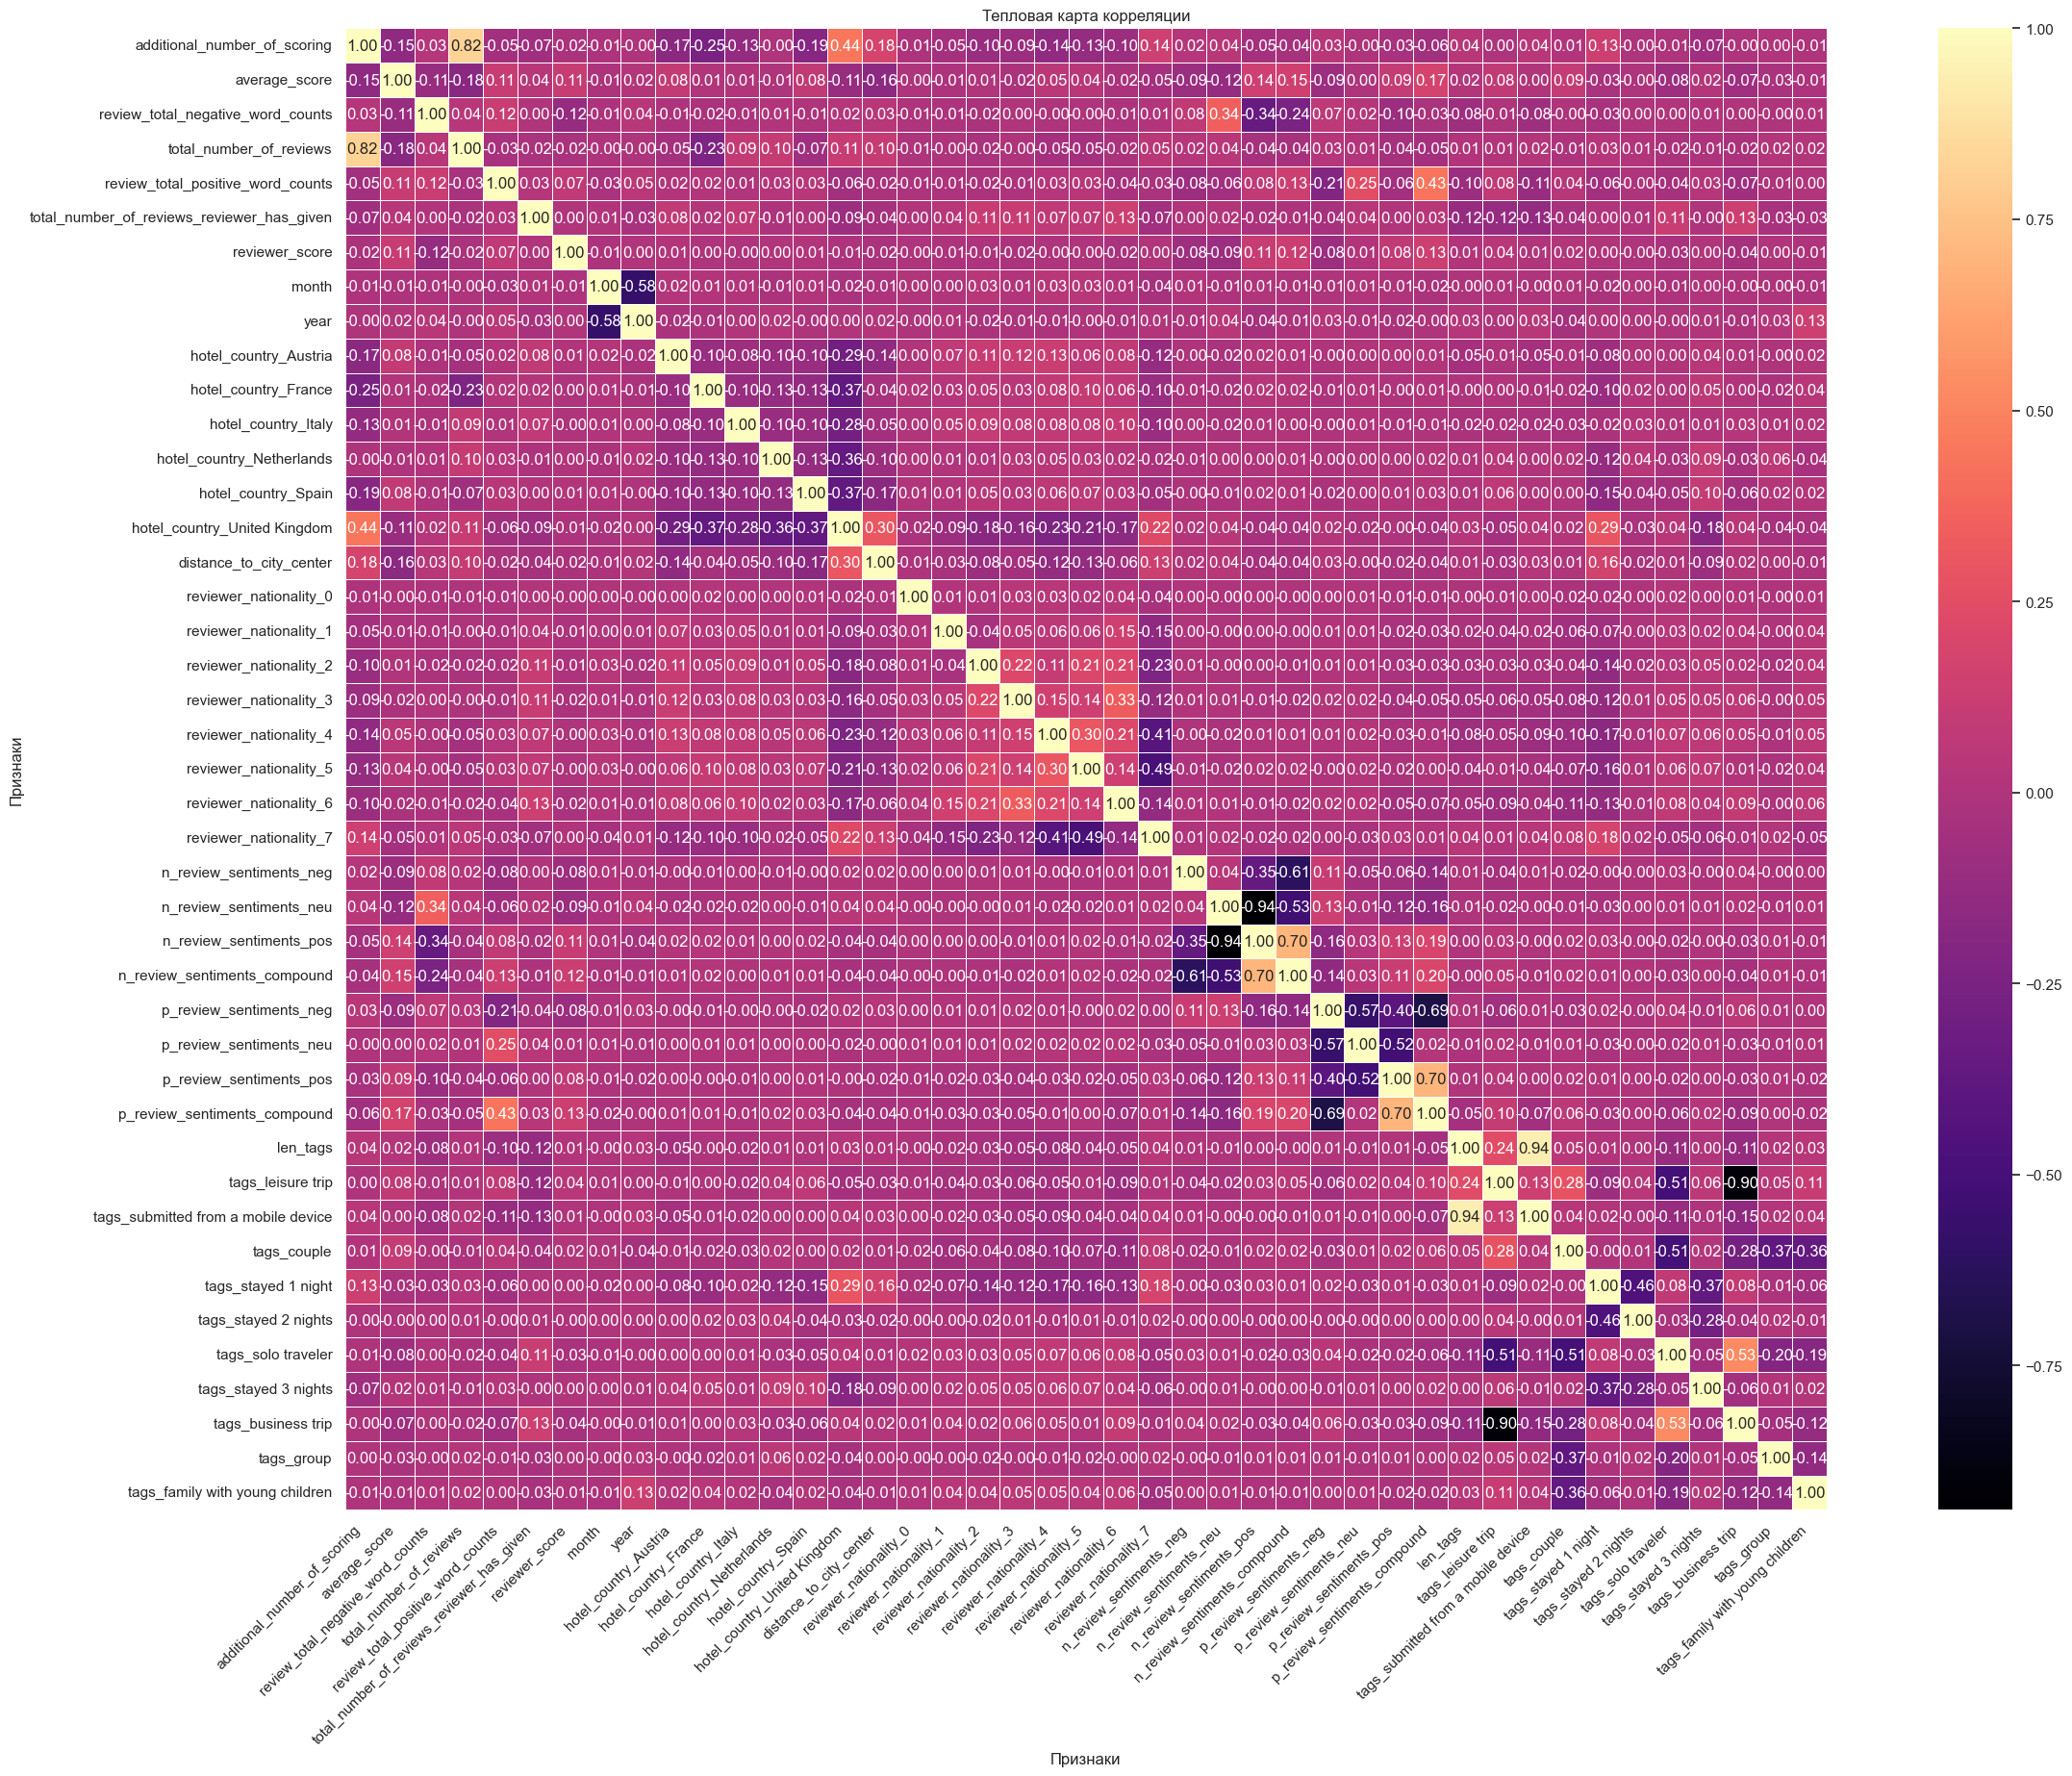

In [69]:
# Посмотрим тепловую карту корреляции

plt.figure(figsize=(30, 20))
correlation_data = data.drop(['sample'], axis=1).corr()
heatmap = sns.heatmap(correlation_data, annot=True, annot_kws={'size': 12, 'ha': 'center'}, fmt='.2f', cmap='magma', square=True, linewidths=0.5, linecolor='white')
heatmap.set_title('Тепловая карта корреляции')
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

<span style="color:#b29aff; font-family: 'Microsoft Sans Serif', Arial, sans-serif; font-size: 20px">
  
На графике есть малое число коррелирующих данных, но мое мнение нет смысла их удалять.

</span>

In [70]:
# посмотрим признаки, которые типов категория, дата, и строки
def getNonNumberTypeFeatures(df):
    """Функция возвращает в списке все признаки из датасета, что подходят под описанные правила

    Args:
        df (pandas.Dataframe()): Датасет

    Returns:
        list: Список признаков
    """
    object_columns = [s for s in data.columns
                    if ((data[s].dtypes == 'object') | \
                        (data[s].dtype.name == 'category') | \
                        (data[s].dtypes == 'datetime64[ns]') |
                        (data[s].dtype.name == 'period[M]'))]
    return object_columns

types_list = getNonNumberTypeFeatures(data)

In [71]:
print(Fore.LIGHTMAGENTA_EX + "\nПризнаки, которые надо удалить:")
for item in types_list:
    print(Fore.CYAN + str(item))


Признаки, которые надо удалить:
hotel_address
review_date
hotel_name
reviewer_nationality
negative_review
positive_review
tags
days_since_review
hotel_city
neg_scores
pos_scores


In [72]:
data.drop(types_list, axis = 1, inplace=True)

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 44 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   sample                                      515738 non-null  int64  
 8   month                                       515738 non-null  int64  
 9   year                                        515738 non-null  int64  
 

<a id = '5'></a>
<p style = "background-color : #ac67ff; border-radius: 5px 5px; padding : 10px">
<p style="color: #b29aff; font-size: 50px;">
    <strong>5. Model</strong>
</p>

<style>
a {
    color: #a63bff !important;
    font-size: 20px !important;
}
</style>
⮬ <a href="#8">к оглавлению</a>

In [74]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [75]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [76]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 43), (386803, 43), (386803, 42), (309442, 42), (77361, 42))

In [77]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
#from sklearn import metrics # инструменты для оценки точности модели

In [78]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [79]:
%%time
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s


CPU times: total: 16min 48s
Wall time: 2min 20s


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


<a id = '5.1'></a>
<p style="color: #b29aff; font-size: 45px;">
    <strong>5.1 Получение средней абсолютной ошибки</strong>
</p>

In [80]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test), 
# метрика Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную 
# процентную ошибку предсказанных значений от фактических:

def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print(Fore.LIGHTMAGENTA_EX + "\nMAPE:")

mape = round(mean_absolute_percentage_error(y_test, y_pred), 2)
mape_str = "{:.2f}".format(mape)

print(Fore.CYAN + mape_str)



MAPE:
12.49


<a id = '6'></a>
<p style = "background-color : #ac67ff; border-radius: 5px 5px; padding : 10px">
<p style="color: #b29aff; font-size: 50px;">
    <strong>6. Conclusion</strong>
</p>

<style>
a {
    color: #a63bff !important;
    font-size: 20px !important;
}
</style>
⮬ <a href="#8">к оглавлению</a>

<AxesSubplot: >

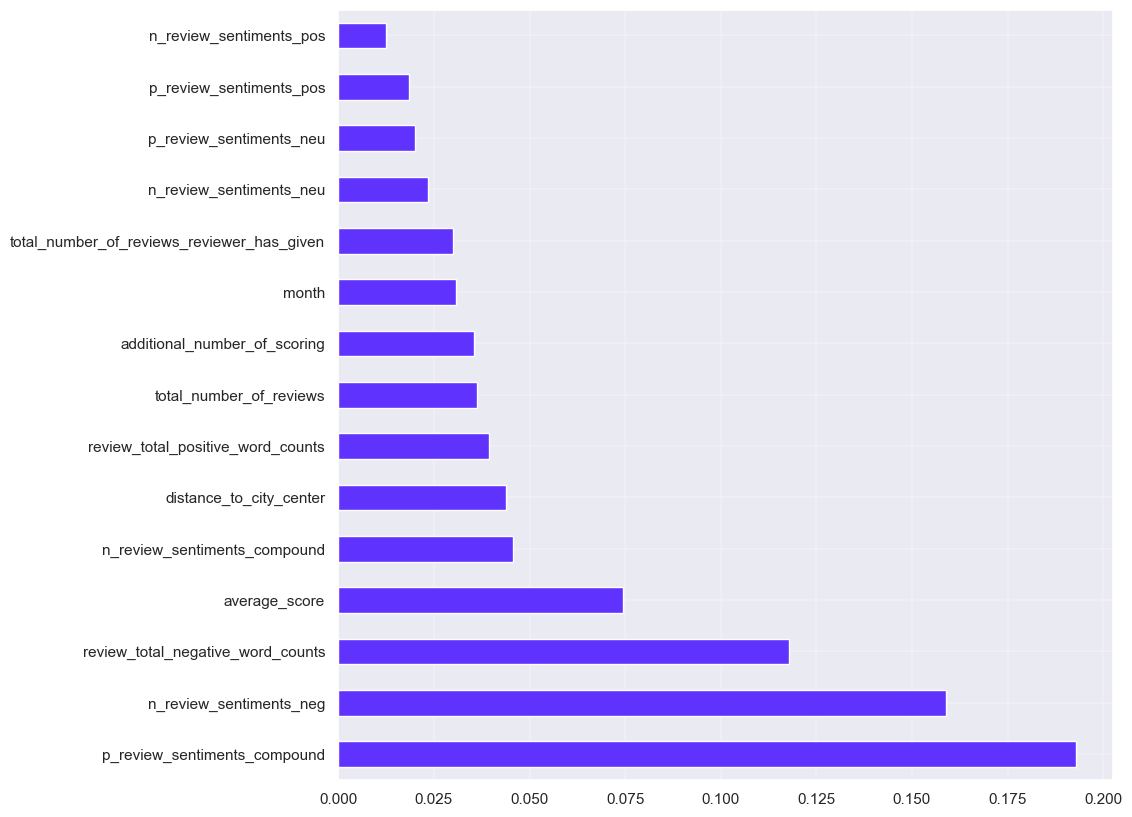

In [81]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

<a id = '7'></a>
<p style = "background-color : #ac67ff; border-radius: 5px 5px; padding : 10px">
<p style="color: #b29aff; font-size: 50px;">
    <strong>7. Submission</strong>
</p>

In [82]:
test_data.sample(3)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,month,year,hotel_country_Austria,...,tags_leisure trip,tags_submitted from a mobile device,tags_couple,tags_stayed 1 night,tags_stayed 2 nights,tags_solo traveler,tags_stayed 3 nights,tags_business trip,tags_group,tags_family with young children
487939,1198,8.5,31,6596,18,8,0.0,3,2016,0,...,1,0,0,1,0,0,0,0,0,0
418852,365,8.3,6,1463,12,1,0.0,8,2016,0,...,1,1,0,0,0,0,0,0,0,1
467356,556,8.0,3,2347,9,6,0.0,5,2017,0,...,0,1,1,1,0,0,0,1,0,0


In [83]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [84]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [85]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


In [86]:
predict_submission

array([8.745, 7.553, 8.521, ..., 8.341, 9.519, 7.457])

In [87]:
list(sample_submission)

['reviewer_score', 'id']

In [88]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.745,488440
1,7.553,274649
2,8.521,374688
3,9.760,404352
4,9.538,451596
5,8.921,302161
6,7.192,317079
7,7.466,13963
8,8.253,159785
9,7.438,195089
